# Day 5: Gaussian Mixture Models

## 🎯 Learning Objectives
- Understand GMM for soft clustering
- Model return distributions
- Build probabilistic trading strategies

---

## 📚 Theory: GMM

### Model
$$p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

### Soft vs Hard Clustering
- **K-Means**: Hard assignment (point belongs to one cluster)
- **GMM**: Soft assignment (probability distribution over clusters)

### Finance Applications
- Return distribution modeling
- Regime detection with uncertainty
- VaR estimation

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.mixture import GaussianMixture
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days")

📥 Downloading data...
✅ Data: 2512 days


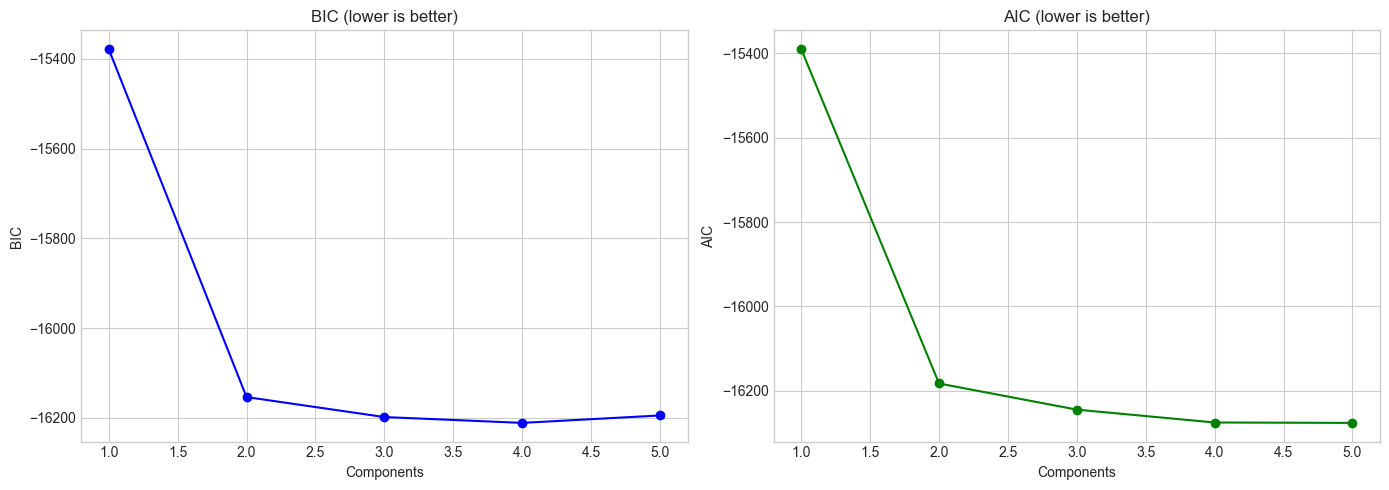


📊 Best number of components: 4


In [2]:
# Fit GMM with different components
X = returns.values.reshape(-1, 1)

n_components_range = range(1, 6)
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    aics.append(gmm.aic(X))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(n_components_range, bics, 'bo-')
axes[0].set_xlabel('Components')
axes[0].set_ylabel('BIC')
axes[0].set_title('BIC (lower is better)')

axes[1].plot(n_components_range, aics, 'go-')
axes[1].set_xlabel('Components')
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC (lower is better)')

plt.tight_layout()
plt.show()

best_n = n_components_range[np.argmin(bics)]
print(f"\n📊 Best number of components: {best_n}")

In [3]:
# Fit GMM with 2 components (high/low volatility regimes)
n_components = 2
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X)

# Parameters
print("\n" + "="*60)
print("GMM PARAMETERS")
print("="*60)
for i in range(n_components):
    print(f"\nComponent {i+1}:")
    print(f"  Weight: {gmm.weights_[i]:.3f}")
    print(f"  Mean: {gmm.means_[i][0]:.4%}")
    print(f"  Std: {np.sqrt(gmm.covariances_[i][0][0]):.4%}")

# Label regimes
low_vol_idx = np.argmin(gmm.covariances_[:, 0, 0])
regime_names = {low_vol_idx: 'Low Vol', 1 - low_vol_idx: 'High Vol'}


GMM PARAMETERS

Component 1:
  Weight: 0.269
  Mean: -0.1345%
  Std: 1.9386%

Component 2:
  Weight: 0.731
  Mean: 0.1378%
  Std: 0.5981%


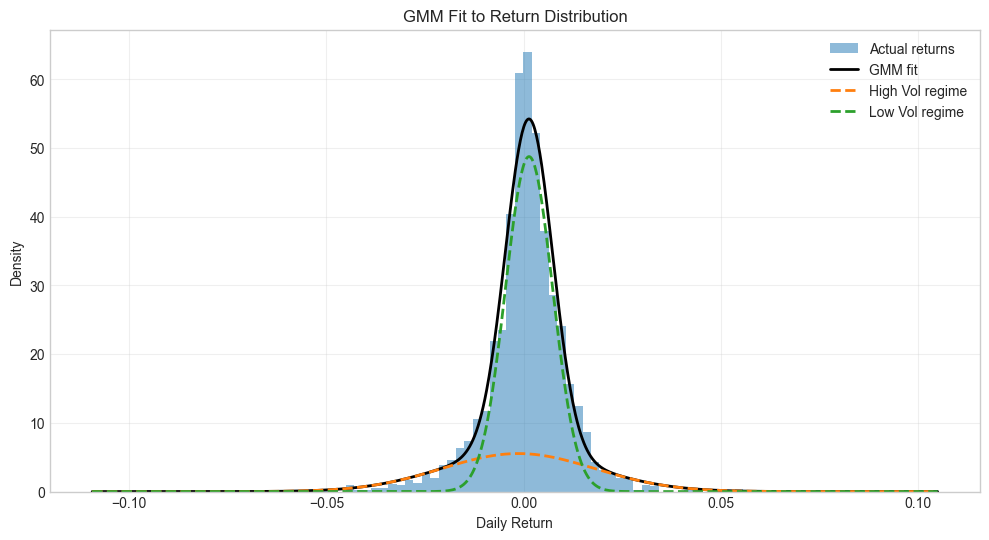

In [4]:
# Visualize GMM fit
x_range = np.linspace(returns.min(), returns.max(), 1000).reshape(-1, 1)
log_prob = gmm.score_samples(x_range)
pdf = np.exp(log_prob)

# Individual component PDFs
responsibilities = gmm.predict_proba(x_range)
component_pdfs = []
for i in range(n_components):
    component_pdf = gmm.weights_[i] * stats.norm.pdf(
        x_range.flatten(), 
        gmm.means_[i][0], 
        np.sqrt(gmm.covariances_[i][0][0])
    )
    component_pdfs.append(component_pdf)

plt.figure(figsize=(12, 6))
plt.hist(returns, bins=100, density=True, alpha=0.5, label='Actual returns')
plt.plot(x_range, pdf, 'k-', linewidth=2, label='GMM fit')
for i, comp_pdf in enumerate(component_pdfs):
    plt.plot(x_range, comp_pdf, '--', linewidth=2, label=f'{regime_names[i]} regime')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.title('GMM Fit to Return Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

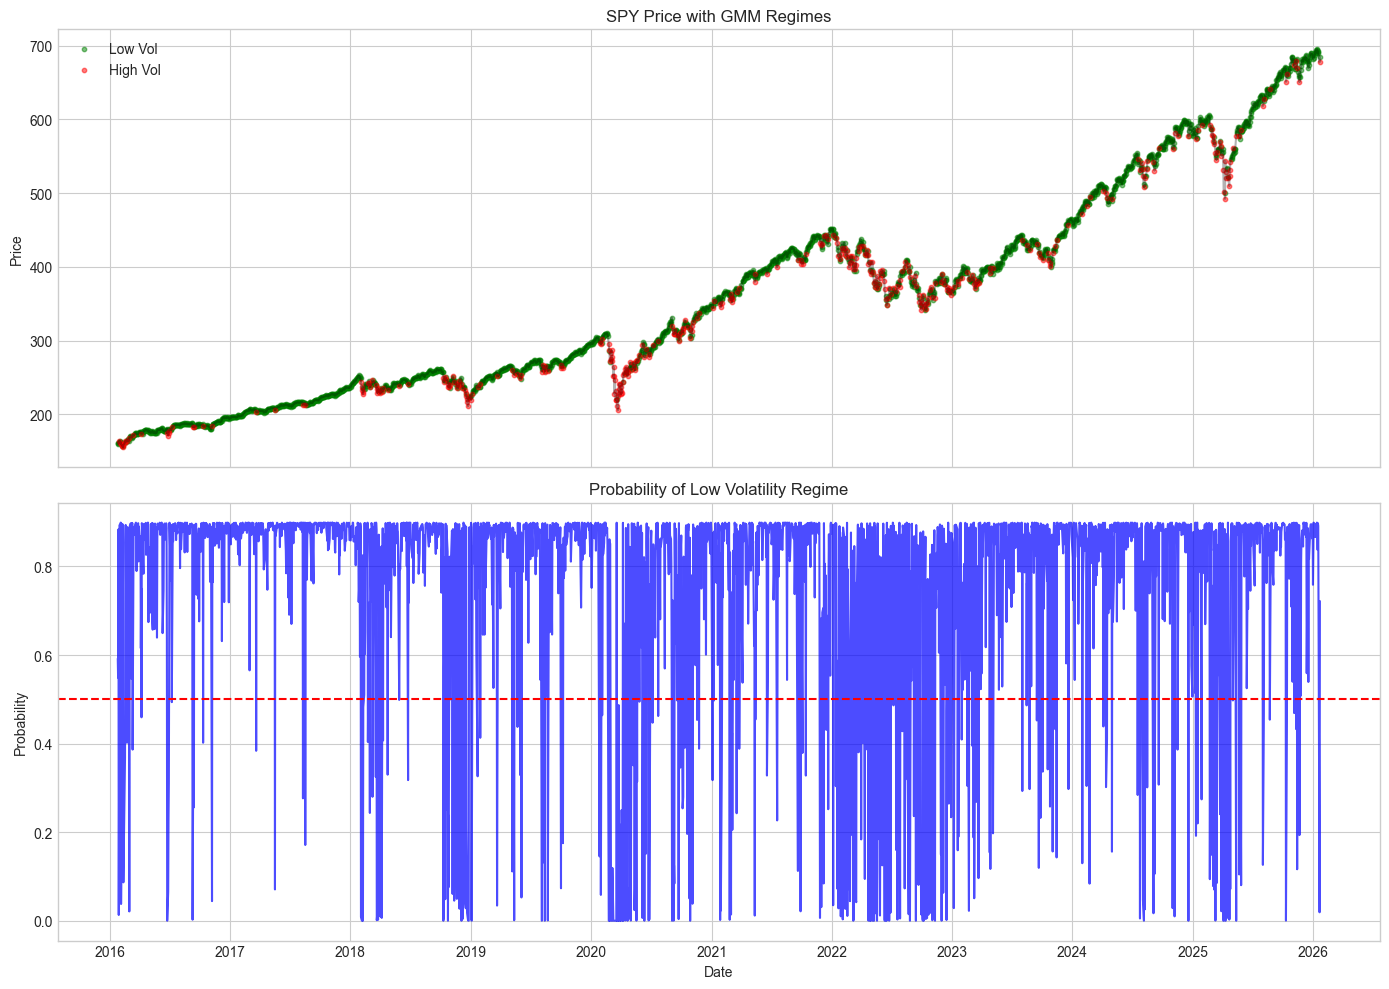

In [5]:
# Regime classification
df = pd.DataFrame(index=returns.index)
df['return'] = returns
df['regime'] = gmm.predict(X)
df['regime_prob'] = gmm.predict_proba(X)[:, low_vol_idx]  # Prob of low vol
df['regime_name'] = df['regime'].map(regime_names)

# Plot regimes
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

price_aligned = prices.loc[df.index]
colors = {'Low Vol': 'green', 'High Vol': 'red'}

axes[0].plot(price_aligned.index, price_aligned.values, 'k-', alpha=0.3)
for regime in df['regime_name'].unique():
    mask = df['regime_name'] == regime
    axes[0].scatter(df.index[mask], price_aligned[mask], 
                   c=colors[regime], label=regime, alpha=0.5, s=10)
axes[0].set_title(f'{ticker} Price with GMM Regimes')
axes[0].set_ylabel('Price')
axes[0].legend()

axes[1].plot(df.index, df['regime_prob'], 'b-', alpha=0.7)
axes[1].axhline(y=0.5, color='r', linestyle='--')
axes[1].set_title('Probability of Low Volatility Regime')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

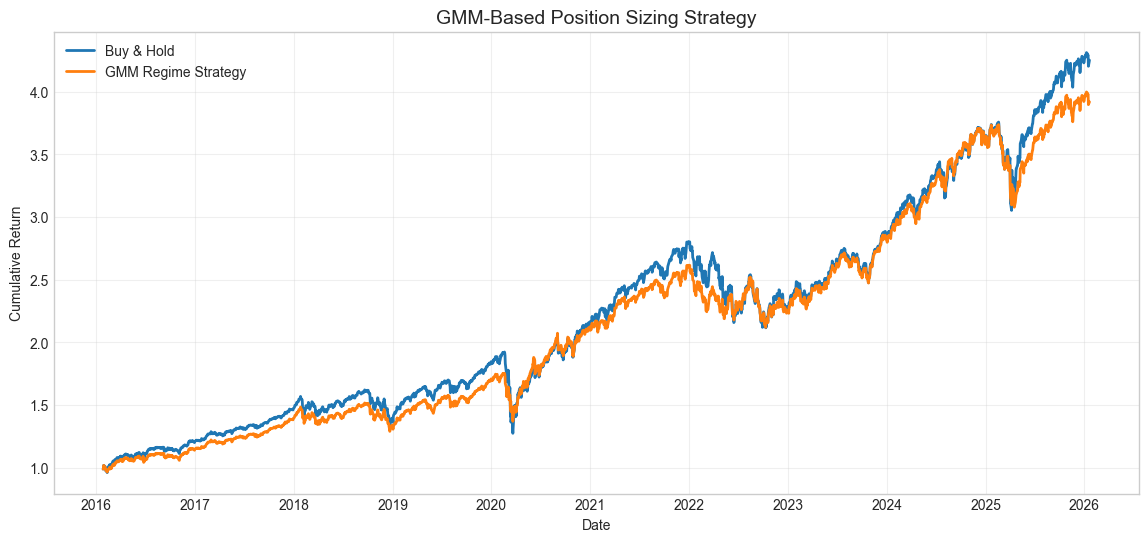

In [6]:
# GMM-based trading strategy: Adjust position based on regime probability
df['next_return'] = df['return'].shift(-1)

# Strategy: Scale position by confidence in low vol regime
# High prob of low vol = larger position, high vol = smaller/no position
df['position'] = np.where(df['regime_prob'] > 0.5, 1, 0.5)  # Full/half position
df['strategy_return'] = df['position'] * df['next_return']

df = df.dropna()
df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='GMM Regime Strategy', linewidth=2)
plt.title('GMM-Based Position Sizing Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(df['next_return'], df['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)
print(f"{'Buy & Hold':<20} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'GMM Strategy':<20} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                325.18%       0.62    -33.72%
GMM Strategy              291.95%       0.67    -21.88%


In [8]:
# VaR estimation using GMM
confidence_levels = [0.95, 0.99]

print("\n" + "="*60)
print("VALUE AT RISK (GMM vs Normal)")
print("="*60)

for conf in confidence_levels:
    # Normal VaR (use returns as a Series)
    ret_vals = returns['return'].values if isinstance(returns, pd.DataFrame) else returns.values
    normal_var = stats.norm.ppf(1 - conf, ret_vals.mean(), ret_vals.std())
    
    # GMM VaR (sample-based)
    samples = gmm.sample(100000)[0]
    gmm_var = np.percentile(samples, (1 - conf) * 100)
    
    print(f"\n{conf*100:.0f}% VaR:")
    print(f"  Normal: {-normal_var:.2%}")
    print(f"  GMM: {-float(gmm_var):.2%}")


VALUE AT RISK (GMM vs Normal)


KeyError: 'return'

In [ ]:
# Current regime prediction
latest_return = returns.iloc[-1]
latest_regime_prob = gmm.predict_proba([[latest_return]])[0]

print("\n" + "="*60)
print(f"📊 CURRENT REGIME FOR {ticker}")
print("="*60)
print(f"\nDate: {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Last Return: {latest_return:.2%}")
print(f"\nRegime Probabilities:")
print(f"  Low Volatility: {latest_regime_prob[low_vol_idx]:.1%}")
print(f"  High Volatility: {latest_regime_prob[1-low_vol_idx]:.1%}")

predicted_regime = regime_names[np.argmax(latest_regime_prob)]
position = 'Full position' if latest_regime_prob[low_vol_idx] > 0.5 else 'Reduced position'
print(f"\n🎯 Predicted Regime: {predicted_regime}")
print(f"📈 Recommendation: {position}")

---

## 🏢 Real-World Applications

| Company | GMM Use Case |
|---------|-------------|
| Man AHL | Return modeling |
| Quantopian | Regime detection |
| Banks | VaR estimation |

---
## 📅 Tomorrow: t-SNE & UMAP Visualization